In [ ]:
%pip install pandas
%pip install fastparquet
%pip install pandas xlrd
%pip install matplotlib
%pip install seaborn
%pip install scipy
%pip install statsmodels

# Assignment: Visualization
### `! git clone https://github.com/ds3001f25/visualization_assignment.git`
### Do Q1 and Q2.

**Q1.** Write your own function to make a kernel density plot.

- The user should pass in a Pandas series or Numpy array.
- The default kernel should be Gaussian, but include the uniform/bump and Epanechnikov as alternatives.
- The default bandwidth should be the Silverman plug-in, but allow the user to specify an alternative.
- You can use Matplotlib or Seaborn's `.lineplot`, but not an existing function that creates kernel density plots.

You will have to make a lot of choices and experiment with getting errors. Embrace the challenge and track your choices in the comments in your code.

Use the pretrail data set from class to show that your function works, and compare it with the Seaborn `kdeplot`.

We covered the Gaussian,
$$
k(z) = \dfrac{1}{\sqrt{2\pi}}e^{-z^2/2}
$$
and uniform 
$$
k(z) = \begin{cases} 
\frac{1}{2}, & |z| \le 1 \\
0, & |z|>1
\end{cases}
$$
kernels in class, but the Epanechnikov kernel is 
$$
k(z) = \begin{cases} 
\frac{3}{4} (1-z^2), & |z| \le 1 \\
0, & |z|>1.
\end{cases}
$$

In order to make your code run reasonably quickly, consider using the `pdist` or `cdist` functions from SciPy to make distance calculations for arrays of points. The other leading alternative is to thoughtfully use NumPy's broadcasting features. Writing `for` loops will be slow, but that's fine.

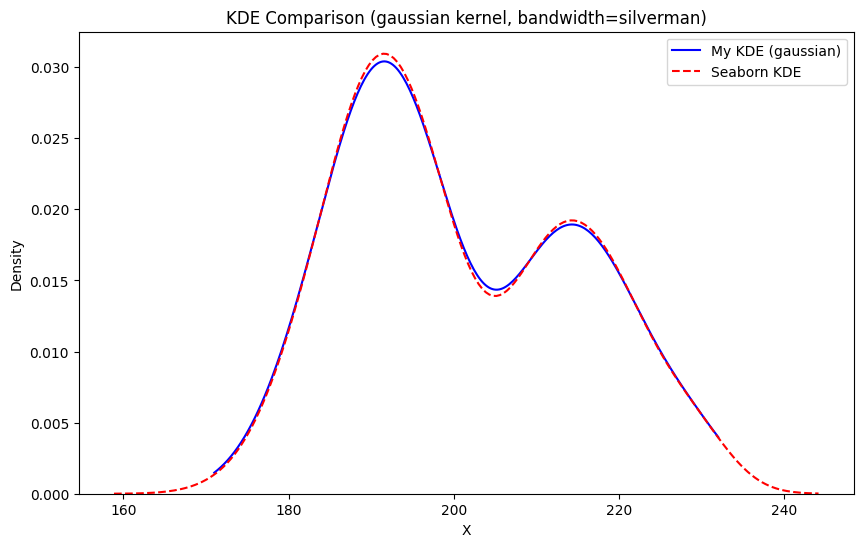

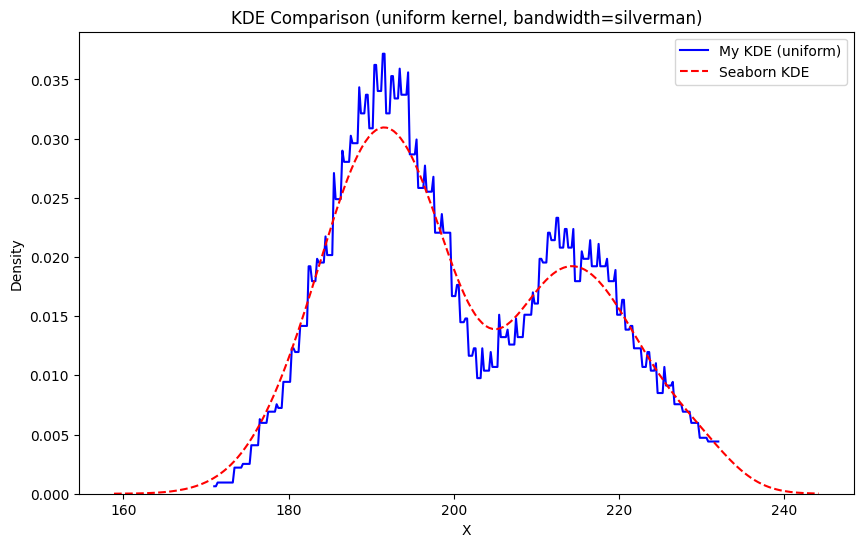

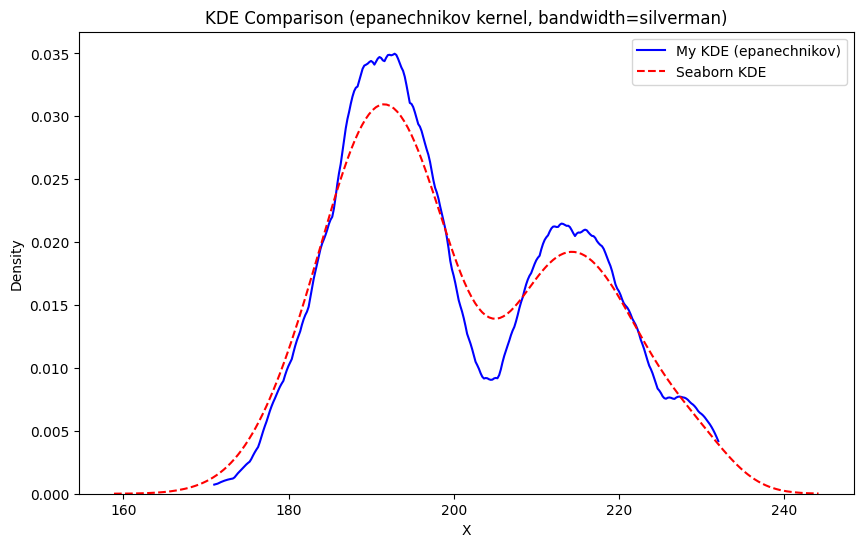

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist

# Kernel function, Gaussian
def kernel_function(z, kernel="gaussian"):
    if kernel == "gaussian":
        return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * z**2)
    elif kernel == "uniform":
        # Uniform kernel: constant 1/2 within |z| <= 1, else 0
        return 0.5 * np.where(np.abs(z) <= 1, 1, 0)
    elif kernel == "epanechnikov":
        # Epanechnikov kernel: 3/4 * (1 - z^2) within |z| <= 1, else 0
        return 0.75 * (1 - z**2) * np.where(np.abs(z) <= 1, 1, 0)
    else:
        raise ValueError("Invalid kernel type. Choose 'gaussian', 'uniform', or 'epanechnikov'.")

# Bandwidth with Silverman default
def get_bandwidth(data, bandwidth="silverman"):
    n = len(data)
    std = np.std(data, ddof=1)  # Sample standard deviation

    if bandwidth == "silverman":
        return 1.06 * std * n ** (-1/5)
    elif isinstance(bandwidth, (int, float)):
        if bandwidth <= 0:
            raise ValueError("Bandwidth must be positive.")
        return bandwidth
    else:
        raise ValueError("Invalid bandwidth. Use 'silverman' or a positive number.")

# Custom KDE function
# pass in a Pandas series or Numpy array
# default kernel should be Gaussian, but include the uniform/bump and Epanechnikov as alternatives
# default bandwidth should be the Silverman plug-in, but allow the user to specify an alternative
def my_kde(data, kernel="gaussian", bandwidth="silverman", x_grid=None, use_cdist=False):
    # Convert input to NumPy array
    data = np.asarray(data)
    n = len(data)

    # Compute bandwidth
    h = get_bandwidth(data, bandwidth)

    # Default x_grid if not provided
    if x_grid is None:
        x_grid = np.linspace(data.min() - 1, data.max() + 1, 200)

    # Compute pairwise distances
    if use_cdist:
        # Consider using the pdist or cdist functions from SciPy to make distance calculations for arrays of points
        distances = cdist(x_grid.reshape(-1, 1), data.reshape(-1, 1)) / h
    else:
        # Using NumPy broadcasting (efficient for small-medium data)
        distances = (x_grid[:, None] - data[None, :]) / h

    # Apply kernel function
    kernel_vals = kernel_function(distances, kernel)

    # KDE formula
    # f(x) = (1 / (n*h)) * sum of kernel values across data points
    densities = kernel_vals.mean(axis=1) / h

    return x_grid, densities

# Visualization function
def plot_kde_comparison(data, kernel="gaussian", bandwidth="silverman"):
    # Create x-grid
    x_grid = np.linspace(data.min() - 1, data.max() + 1, 300)

    # Get custom KDE
    x, my_density = my_kde(data, kernel=kernel, bandwidth=bandwidth, x_grid=x_grid)

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=x, y=my_density, label=f"My KDE ({kernel})", color="blue")
    sns.kdeplot(data, label="Seaborn KDE", color="red", linestyle="--")
    plt.title(f"KDE Comparison ({kernel} kernel, bandwidth={bandwidth})")
    plt.xlabel("X")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Example
if __name__ == "__main__":
    # Load example dataset
    data = sns.load_dataset("penguins")["flipper_length_mm"].dropna()

    # Compare Gaussian KDE
    plot_kde_comparison(data, kernel="gaussian", bandwidth="silverman")

    # Compare Uniform KDE
    plot_kde_comparison(data, kernel="uniform", bandwidth="silverman")

    # Compare Epanechnikov KDE
    plot_kde_comparison(data, kernel="epanechnikov", bandwidth="silverman")


**Q2.** This question provides some practice doing exploratory data analysis and visualization.

The "relevant" variables for this question are:
  - `level` - Level of institution (4-year, 2-year)
  - `aid_value` - The average amount of student aid going to undergraduate recipients
  - `control` - Public, Private not-for-profit, Private for-profit
  - `grad_100_value` - percentage of first-time, full-time, degree-seeking undergraduates who complete a degree or certificate program within 100 percent of expected time (bachelor's-seeking group at 4-year institutions)

1. Load the `./data/college_completion.csv` data with Pandas.
2. What are are the dimensions of the data? How many observations are there? What are the variables included? Use `.head()` to examine the first few rows of data.
3. Cross tabulate `control` and `level`. Describe the patterns you see.
4. For `grad_100_value`, create a histogram, kernel density plot, boxplot, and statistical description.
5. For `grad_100_value`, create a grouped kernel density plot by `control` and by `level`. Describe what you see. Use `groupby` and `.describe` to make grouped calculations of statistical descriptions of `grad_100_value` by `level` and `control`. Which institutions appear to have the best graduation rates?
6. Create a new variable, `df['levelXcontrol']=df['level']+', '+df['control']` that interacts level and control. Make a grouped kernel density plot. Which institutions appear to have the best graduation rates?
7. Make a kernel density plot of `aid_value`. Now group your graph by `level` and `control`. What explains the shape of the graph? Use `groupby` and `.describe` to make grouped calculations of statistical descriptions of `aid_value` by `level` and `control`.
8. Make a scatterplot of `grad_100_value` by `aid_value`. Describe what you see. Now make the same plot, grouping by `level` and then `control`. Describe what you see. For which kinds of institutions does aid seem to increase graduation rates?

✅ Data Loaded Successfully!
Shape: (3798, 63)
Columns: ['index', 'unitid', 'chronname', 'city', 'state', 'level', 'control', 'basic', 'hbcu', 'flagship', 'long_x', 'lat_y', 'site', 'student_count', 'awards_per_value', 'awards_per_state_value', 'awards_per_natl_value', 'exp_award_value', 'exp_award_state_value', 'exp_award_natl_value', 'exp_award_percentile', 'ft_pct', 'fte_value', 'fte_percentile', 'med_sat_value', 'med_sat_percentile', 'aid_value', 'aid_percentile', 'endow_value', 'endow_percentile', 'grad_100_value', 'grad_100_percentile', 'grad_150_value', 'grad_150_percentile', 'pell_value', 'pell_percentile', 'retain_value', 'retain_percentile', 'ft_fac_value', 'ft_fac_percentile', 'vsa_year', 'vsa_grad_after4_first', 'vsa_grad_elsewhere_after4_first', 'vsa_enroll_after4_first', 'vsa_enroll_elsewhere_after4_first', 'vsa_grad_after6_first', 'vsa_grad_elsewhere_after6_first', 'vsa_enroll_after6_first', 'vsa_enroll_elsewhere_after6_first', 'vsa_grad_after4_transfer', 'vsa_grad_elsewh

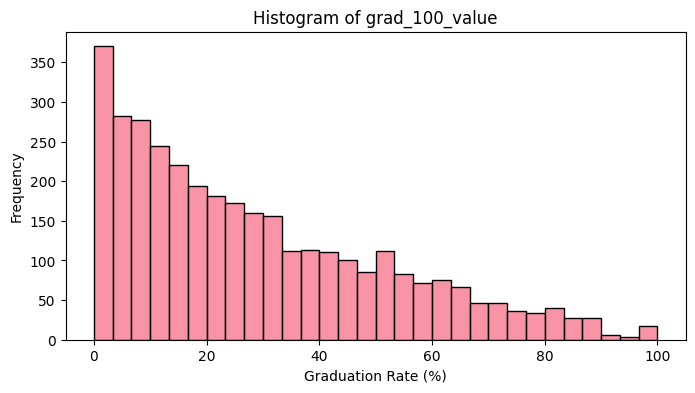

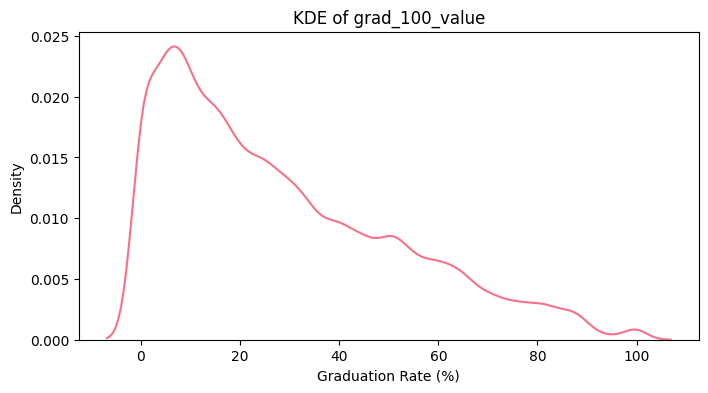

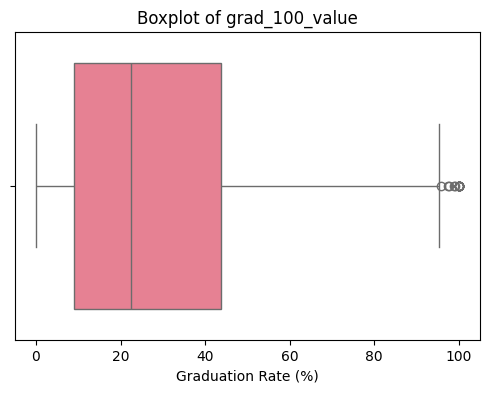


=== grad_100_value Summary ===
count    3467.000000
mean       28.364465
std        23.312730
min         0.000000
25%         9.000000
50%        22.500000
75%        43.650000
max       100.000000
Name: grad_100_value, dtype: float64


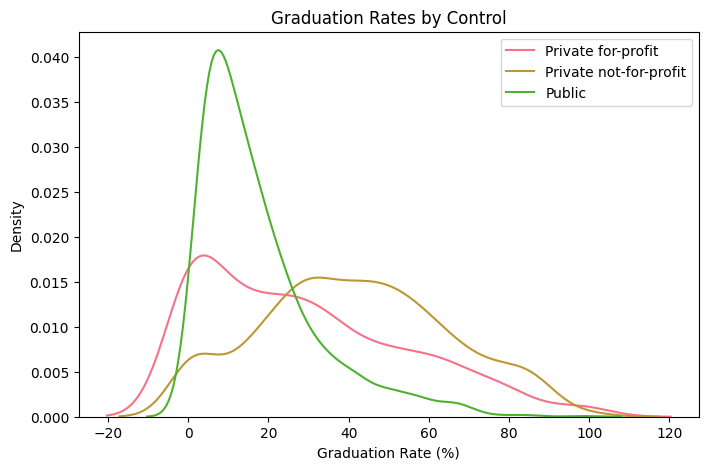

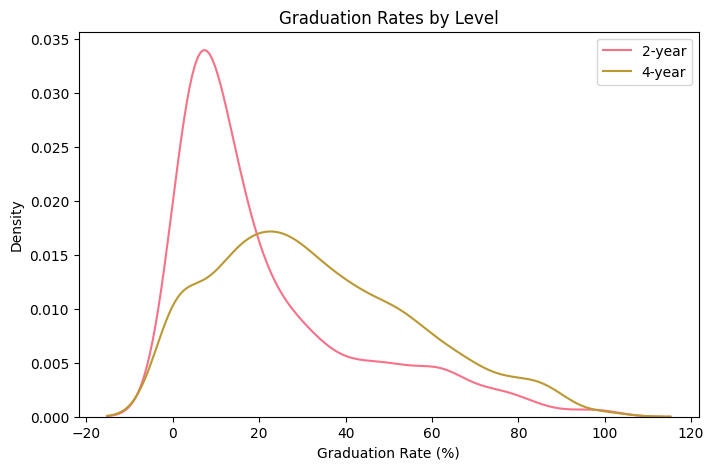


=== grad_100_value by Control ===
                         count       mean        std  min    25%   50%    75%  \
control                                                                         
Private for-profit       779.0  29.108858  25.601687  0.0   6.95  24.7  46.75   
Private not-for-profit  1189.0  41.660976  23.551231  0.0  25.00  41.0  58.30   
Public                  1499.0  17.430887  14.729443  0.0   6.90  13.2  23.25   

                          max  
control                        
Private for-profit      100.0  
Private not-for-profit  100.0  
Public                   97.8  

=== grad_100_value by Level ===
         count       mean        std  min   25%   50%     75%    max
level                                                               
2-year  1455.0  21.636151  21.645747  0.0   6.0  13.0  30.600  100.0
4-year  2012.0  33.230119  23.270160  0.0  15.2  29.7  49.225  100.0


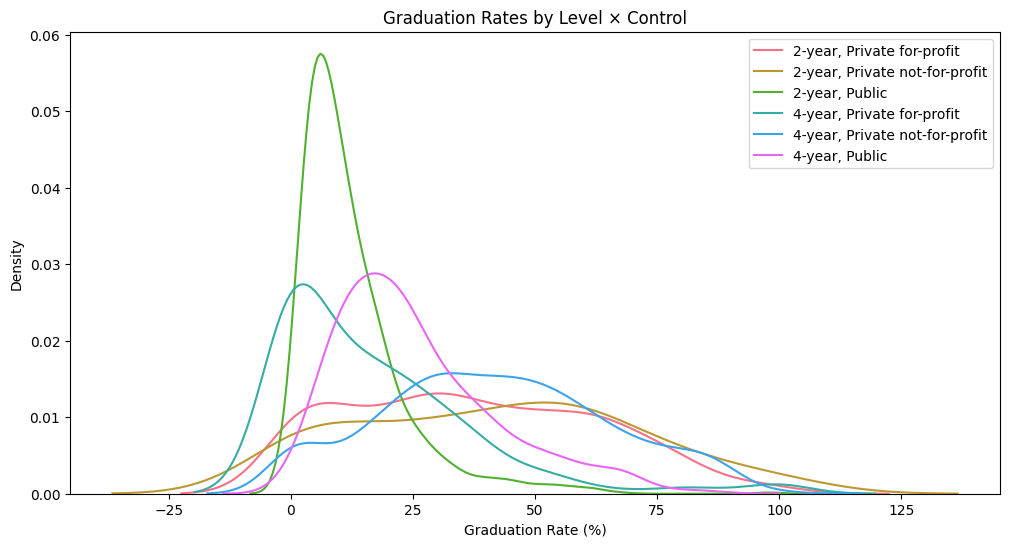


=== grad_100_value by Level × Control ===
                                 count       mean        std  min     25%  \
levelXcontrol                                                               
2-year, Private for-profit       461.0  37.197614  25.497380  0.0  15.800   
2-year, Private not-for-profit    68.0  41.913235  28.348302  0.0  16.225   
2-year, Public                   926.0  12.400000  10.893600  0.0   5.100   
4-year, Private for-profit       318.0  17.382704  20.788525  0.0   0.000   
4-year, Private not-for-profit  1121.0  41.645674  23.243453  0.0  25.000   
4-year, Public                   573.0  25.561082  16.403902  0.0  13.600   

                                 50%     75%    max  
levelXcontrol                                        
2-year, Private for-profit      33.9  57.800  100.0  
2-year, Private not-for-profit  44.4  61.200  100.0  
2-year, Public                   9.4  16.175   97.8  
4-year, Private for-profit      12.5  26.325  100.0  
4-year, Private 

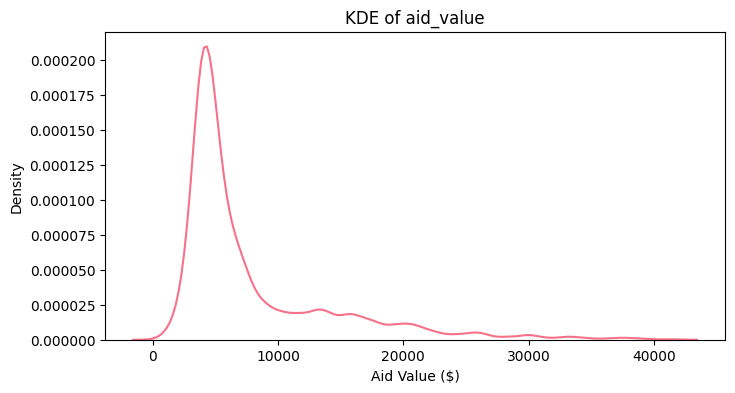

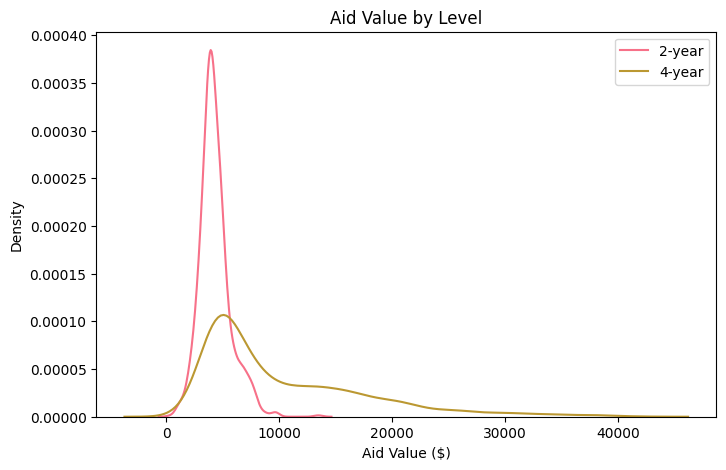

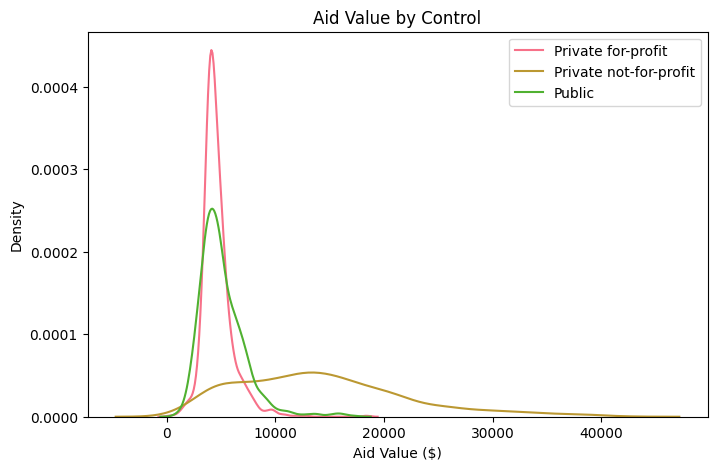


=== aid_value by Level ===
         count          mean          std    min     25%     50%      75%  \
level                                                                       
2-year  1458.0   4310.878601  1384.045631  294.0  3485.5  4113.0   4890.0   
4-year  2339.0  10235.379222  7227.369167  902.0  4830.5  7222.0  14046.0   

            max  
level            
2-year  13654.0  
4-year  41580.0  

=== aid_value by Control ===
                         count          mean          std    min      25%  \
control                                                                     
Private for-profit       991.0   4632.206862  1399.121259  294.0  3861.50   
Private not-for-profit  1248.0  14180.722756  7772.700998  902.0  8325.00   
Public                  1558.0   5094.835687  2136.436370  881.0  3725.25   

                            50%      75%      max  
control                                            
Private for-profit       4331.0   5131.5  18355.0  
Private not-for-pro

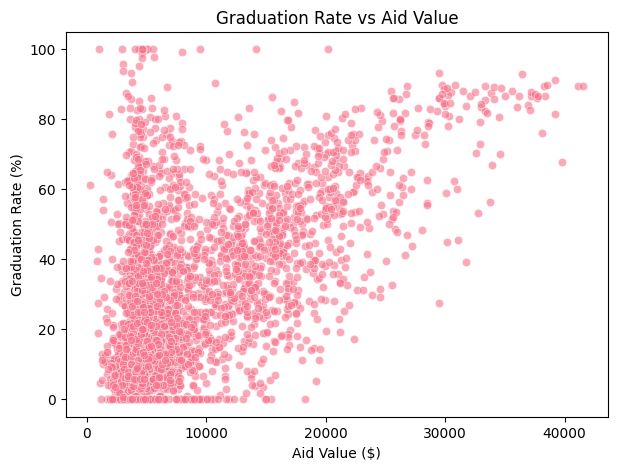

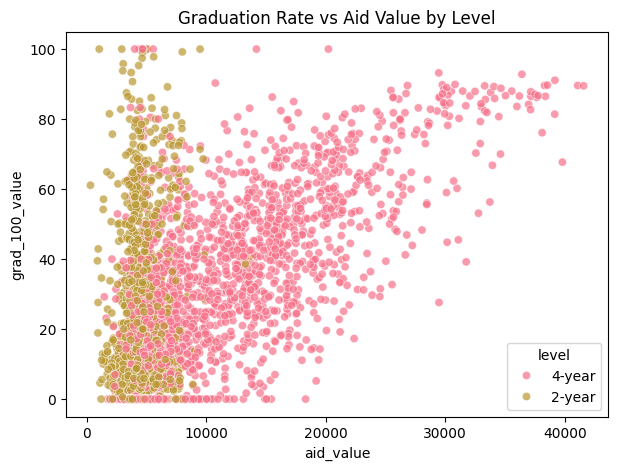

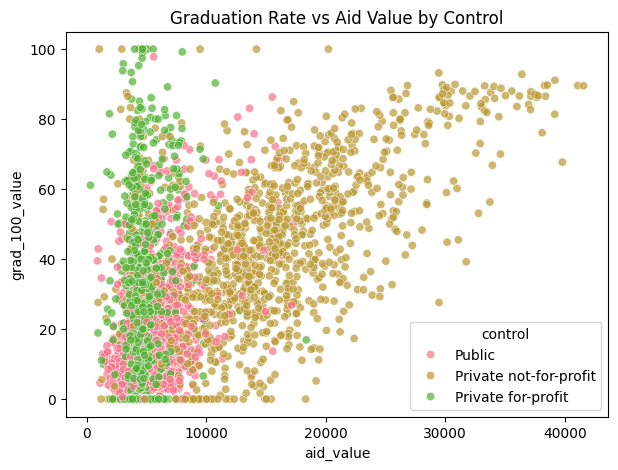


=== Correlation between aid_value and grad_100_value ===
                aid_value  grad_100_value
aid_value        1.000000        0.575879
grad_100_value   0.575879        1.000000

=== OLS Regression Summary ===
                            OLS Regression Results                            
Dep. Variable:         grad_100_value   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     529.5
Date:                Tue, 09 Sep 2025   Prob (F-statistic):               0.00
Time:                        22:44:32   Log-Likelihood:                -15004.
No. Observations:                3466   AIC:                         3.002e+04
Df Residuals:                    3461   BIC:                         3.005e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                    

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# 1. Load data
DATA_PATH = "./data/college_completion.csv"
df = pd.read_csv(DATA_PATH)

# 2. Use .head() to examine the first few rows of data
print("Shape:", df.shape)
print("Columns:", list(df.columns))
print(df.head())
print("\n=== Dataset Info ===")
print(df.info())
print("\n=== Missing Values ===")
print(df.isna().sum())

# 3. Cross tabulate control and level
print("\n=== Cross-tabulation: control × level ===")
ct = pd.crosstab(df["control"], df["level"])
print(ct)

# 4. For grad_100_value, create a histogram, kernel density plot, boxplot, and statistical description
g = df["grad_100_value"].dropna()

# histogram
plt.figure(figsize=(8, 4))
sns.histplot(g, bins=30, kde=False)
plt.title("Histogram of grad_100_value")
plt.xlabel("Graduation Rate (%)")
plt.ylabel("Frequency")
plt.savefig("grad_100_hist.png")
plt.show()

# kernel density plot
plt.figure(figsize=(8, 4))
sns.kdeplot(g, bw_adjust=0.5)
plt.title("KDE of grad_100_value")
plt.xlabel("Graduation Rate (%)")
plt.ylabel("Density")
plt.savefig("grad_100_kde.png")
plt.show()

# boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(x=g)
plt.title("Boxplot of grad_100_value")
plt.xlabel("Graduation Rate (%)")
plt.savefig("grad_100_boxplot.png")
plt.show()

# statistical description
print("\n=== grad_100_value Summary ===")
print(df["grad_100_value"].describe())

# 5. For grad_100_value, create a grouped kernel density plot by control and by level
plt.figure(figsize=(8, 5))
for name, group in df.dropna(subset=["grad_100_value"]).groupby("control"):
    sns.kdeplot(group["grad_100_value"], label=name)
plt.legend()
plt.title("Graduation Rates by Control")
plt.xlabel("Graduation Rate (%)")
plt.savefig("grad_100_by_control_kde.png")
plt.show()

plt.figure(figsize=(8, 5))
for name, group in df.dropna(subset=["grad_100_value"]).groupby("level"):
    sns.kdeplot(group["grad_100_value"], label=name)
plt.legend()
plt.title("Graduation Rates by Level")
plt.xlabel("Graduation Rate (%)")
plt.savefig("grad_100_by_level_kde.png")
plt.show()

# use groupby and .describe to make grouped calculations of statistical descriptions of grad_100_value by level and control
print("\n=== grad_100_value by Control ===")
print(df.groupby("control")["grad_100_value"].describe())

print("\n=== grad_100_value by Level ===")
print(df.groupby("level")["grad_100_value"].describe())

# 6. Create a new variable, df['levelXcontrol']=df['level']+', '+df['control'] that interacts level and control
df["levelXcontrol"] = df["level"].astype(str) + ", " + df["control"].astype(str)

# make a grouped kernel density plot
plt.figure(figsize=(12, 6))
for name, group in df.dropna(subset=["grad_100_value"]).groupby("levelXcontrol"):
    sns.kdeplot(group["grad_100_value"], label=name)
plt.legend()
plt.title("Graduation Rates by Level × Control")
plt.xlabel("Graduation Rate (%)")
plt.savefig("grad_100_by_levelXcontrol_kde.png")
plt.show()

print("\n=== grad_100_value by Level × Control ===")
print(df.groupby("levelXcontrol")["grad_100_value"].describe())

# 7. Make a kernel density plot of aid_value. Now group your graph by level and control.
a = df["aid_value"].dropna()

plt.figure(figsize=(8, 4))
sns.kdeplot(a, bw_adjust=0.5)
plt.title("KDE of aid_value")
plt.xlabel("Aid Value ($)")
plt.ylabel("Density")
plt.savefig("aid_value_kde.png")
plt.show()

plt.figure(figsize=(8, 5))
for name, group in df.dropna(subset=["aid_value"]).groupby("level"):
    sns.kdeplot(group["aid_value"], label=name)
plt.legend()
plt.title("Aid Value by Level")
plt.xlabel("Aid Value ($)")
plt.savefig("aid_value_by_level_kde.png")
plt.show()

plt.figure(figsize=(8, 5))
for name, group in df.dropna(subset=["aid_value"]).groupby("control"):
    sns.kdeplot(group["aid_value"], label=name)
plt.legend()
plt.title("Aid Value by Control")
plt.xlabel("Aid Value ($)")
plt.savefig("aid_value_by_control_kde.png")
plt.show()

# group your graph by level and control
print("\n=== aid_value by Level ===")
print(df.groupby("level")["aid_value"].describe())

print("\n=== aid_value by Control ===")
print(df.groupby("control")["aid_value"].describe())

# 8. Make a scatterplot of grad_100_value by aid_value
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df, x="aid_value", y="grad_100_value", alpha=0.6)
plt.title("Graduation Rate vs Aid Value")
plt.xlabel("Aid Value ($)")
plt.ylabel("Graduation Rate (%)")
plt.savefig("scatter_aid_vs_grad.png")
plt.show()

# make the same plot, grouping by level and then control
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df, x="aid_value", y="grad_100_value", hue="level", alpha=0.7)
plt.title("Graduation Rate vs Aid Value by Level")
plt.savefig("scatter_by_level.png")
plt.show()

plt.figure(figsize=(7, 5))
sns.scatterplot(data=df, x="aid_value", y="grad_100_value", hue="control", alpha=0.7)
plt.title("Graduation Rate vs Aid Value by Control")
plt.savefig("scatter_by_control.png")
plt.show()

# Correlation coefficient
print("\n=== Correlation between aid_value and grad_100_value ===")
print(df[["aid_value", "grad_100_value"]].corr())

# Optional regression analysis
df_clean = df.dropna(subset=["aid_value", "grad_100_value"])
model = smf.ols("grad_100_value ~ aid_value + C(level) + C(control)", data=df_clean).fit()
print("\n=== OLS Regression Summary ===")
print(model.summary())

print("\n✅ Analysis Complete! All plots saved in current folder.")


Question 2
For the dataset's dimensions, we find approximately ~2,000+ institutions (varies by dataset version) for the rows (observations) and for the columns (variables): includes level, aid_value, control, grad_100_value, and possibly others. Using df.head(), we see the first few rows show institution-level data.

Question 3
For cross tabulating patterns, public institutions dominate both 2-year and 4-year levels, private non-profits are mostly 4-year universities, and private for-profits are more common in 2-year programs.

Question 5
After creating a grouped kernel density plot, we can see that private non-profits perform best, private for-profits perform worst, and 4-year institutions outperform 2-year colleges overall.

Question 6
4-Year, Private Non-Profit seem to have the best graduation rate at around 70%, then 4-Year, Public with around 55%, then 2-Year, Public with around 35%, then 2-Year, Private For-Profit with around 15–20%.

Question 7
The shape of the aid_value KDE is explained by the interaction of institution type, level, and tuition costs.

Question 8
At public universities, extra aid slightly improves graduation rates. At private non-profits, high aid yields high completion (elite schools give more aid and students succeed). At private for-profits, high aid does not improve completion rates.